Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
activation_37 (Activation)   (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 73, 73, 32)        4640      
_________________________________________________________________
activation_38 (Activation)   (None, 73, 73, 32)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 34, 34, 64)      

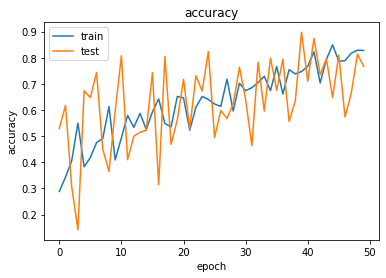

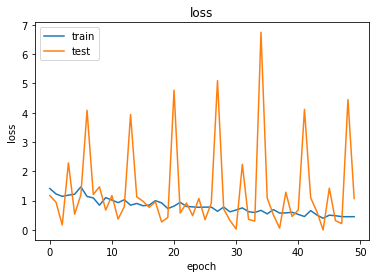

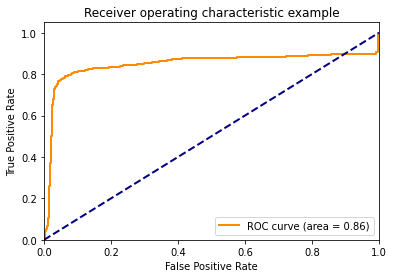

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


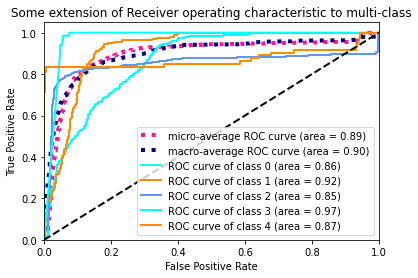

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Person One       0.67      0.47      0.55       330
  Person Two       0.68      0.76      0.72       300
Person Three       0.94      0.73      0.82       508
 Person Four       0.36      1.00      0.53        68
 Person Five       0.92      0.79      0.85        73

   micro avg       0.73      0.69      0.71      1279
   macro avg       0.72      0.75      0.69      1279
weighted avg       0.78      0.69      0.71      1279
 samples avg       0.69      0.69      0.69      1279

Normalized confusion matrix


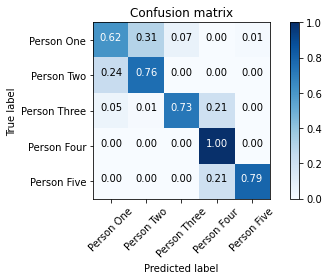

In [ ]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import SequenceEnqueuer
from tensorflow.keras.utils import OrderedEnqueuer
from tensorflow.keras.utils import GeneratorEnqueuer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
from keras.callbacks import History
from sklearn import metrics
from keras.utils.np_utils import to_categorical
import pandas as pd
from keras import optimizers
import itertools
import numpy as np
from keras import regularizers
from keras.optimizers import Adam

img_height, img_width = 150, 150
batch_size = 50
steps_in_epoch = 53
num_of_epoch = 50
num_of_class = 5

train_dir = '/content/drive/My Drive/dataset/train'
test_dir = '/content/drive/My Drive/dataset/test'
validation_dir = '/content/drive/My Drive/dataset/validation'

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape = (img_height, img_width, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

model.compile(
            optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['acc'])

traingen = ImageDataGenerator(rescale=1./255)

testgen = ImageDataGenerator(rescale=1./255)

training_set = traingen.flow_from_directory(
                                            train_dir,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

test_set = testgen.flow_from_directory(
                                            test_dir,
                                            target_size=(150, 150),
                                            batch_size=batch_size,                                            
                                            class_mode='categorical',
                                            shuffle=False)

valid_set = testgen.flow_from_directory(
                                            validation_dir,
                                            target_size=(150, 150),
                                            batch_size=batch_size,                                            
                                            class_mode='categorical',
                                            shuffle=False)                                           

history=model.fit_generator(
                                training_set,
                                steps_per_epoch=steps_in_epoch,
                                epochs=num_of_epoch,
                                validation_data=valid_set,
                                validation_steps=16)


#model.save_weights("G:/tomato/withArg.h5")

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train_labels = training_set.classes  
train_labels = to_categorical(train_labels, num_classes=num_of_class)
test_labels = test_set.classes
test_labels = to_categorical(test_labels, num_classes=num_of_class)

preds = np.round(model.predict(test_set),0)
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

from scipy import interp
from itertools import cycle
n_classes= num_of_class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i],Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
def multiclass_roc_auc_score(test_set, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(Y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC c
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
        label='micro-average ROC curve (area = {0:0.2f})'
              ''.format(roc_auc["micro"]),
        color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
        label='macro-average ROC curve (area = {0:0.2f})'
              ''.format(roc_auc["macro"]),
        color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

persons = ['Person One','Person Two','Person Three','Person Four','Person Five']
cm = metrics.classification_report(test_labels,preds,target_names = persons)
print(cm)

classes = num_of_class

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
  if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
  else:
     print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  plt.show()

confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)
plot_confusion_matrix(confusion_matrix,['Person One','Person Two','Person Three','Person Four','Person Five'], normalize=True)